In [54]:
import csv
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import textwrap

from collections import defaultdict
from datetime import date
from google.api_core.client_options import ClientOptions
from google.cloud import discoveryengine_v1 as discoveryengine
from pathlib import Path

In [56]:
# enter your search query to see timeline of related news
search_query = "terrorism"

In [58]:
# convert csv from Kaggle to jsonl for ingestion into Discovery Engine
# data source: https://www.kaggle.com/datasets/therohk/million-headlines
def csv_to_jsonl(csv_filepath: Path, jsonl_filepath: Path):
    """
    Reads data from a CSV file and converts it into a JSONL file.
    Each row in the CSV is written as a separate JSON object on a new line.

    For each year, 10,000 random entries are processed.

    Args:
    csv_filepath  (Path): The path to the input CSV file.
    json_filepath (Path): The path to the output JSON file.
    """
    
    total_entries = 0
    max_entries_per_year = 10_000
    entries_per_year = defaultdict(int)
    try:
        with open(csv_filepath, mode='r', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            
            with open(jsonl_filepath, mode='w', encoding='utf-8') as jsonlfile:
                for row in reader:

                    try:
                        year = int(row['publish_date'][:4])
                    except (Exception, ValueError,TypeError, IndexError):
                        raise ValueError("Invalid publish_date format", row['publish_date'])
                    
                    if entries_per_year[year] < max_entries_per_year:
                        json_line = json.dumps(row)
                        jsonlfile.write(json_line + '\n')

                        entries_per_year[year] += 1
                        total_entries += 1
                    
        print(f"Successfully converted data to {jsonl_filepath}")
        print(f"Total entries processed: {total_entries}")

        print("Entries per year:")
        for year, count in sorted(entries_per_year.items()):
            print(f"  {year}: {count}")

    except Exception as e:
        print(f"An error occurred: {e}")


csv_path   = Path('news_data/abcnews-date-text.csv')
jsonl_path = Path('news_data/abcnews-data-text.jsonl') 
csv_to_jsonl(csv_filepath=csv_path, jsonl_filepath=jsonl_path)

Successfully converted data to news_data\abcnews-data-text.jsonl
Total entries processed: 190000
Entries per year:
  2003: 10000
  2004: 10000
  2005: 10000
  2006: 10000
  2007: 10000
  2008: 10000
  2009: 10000
  2010: 10000
  2011: 10000
  2012: 10000
  2013: 10000
  2014: 10000
  2015: 10000
  2016: 10000
  2017: 10000
  2018: 10000
  2019: 10000
  2020: 10000
  2021: 10000


In [59]:
# Query Discovery Engine Search API for matching documents

project_id = "arched-aleph-421809"
location = "global"
engine_id = "pre-chronicle_1761879904776"

def search_sample(
    search_query: str,
) -> discoveryengine.services.search_service.pagers.SearchPager:
    #  For more information, refer to:
    # https://cloud.google.com/generative-ai-app-builder/docs/locations#specify_a_multi-region_for_your_data_store
    client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )

    # Create a client
    client = discoveryengine.SearchServiceClient(client_options=client_options)

    # The full resource name of the search app serving config
    serving_config = f"projects/{project_id}/locations/{location}/collections/default_collection/engines/{engine_id}/servingConfigs/default_config"

    # Optional - only supported for unstructured data: Configuration options for search.
    # Refer to the `ContentSearchSpec` reference for all supported fields:
    # https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.types.SearchRequest.ContentSearchSpec
    content_search_spec = discoveryengine.SearchRequest.ContentSearchSpec(
        # For information about snippets, refer to:
        # https://cloud.google.com/generative-ai-app-builder/docs/snippets
        snippet_spec=discoveryengine.SearchRequest.ContentSearchSpec.SnippetSpec(
            return_snippet=True
        ),
        # For information about search summaries, refer to:
        # https://cloud.google.com/generative-ai-app-builder/docs/get-search-summaries
        summary_spec=discoveryengine.SearchRequest.ContentSearchSpec.SummarySpec(
            summary_result_count=5,
            include_citations=True,
            ignore_adversarial_query=True,
            ignore_non_summary_seeking_query=True,
            model_prompt_spec=discoveryengine.SearchRequest.ContentSearchSpec.SummarySpec.ModelPromptSpec(
                preamble="YOUR_CUSTOM_PROMPT"
            ),
            model_spec=discoveryengine.SearchRequest.ContentSearchSpec.SummarySpec.ModelSpec(
                version="stable",
            ),
        ),
    )

    # Refer to the `SearchRequest` reference for all supported fields:
    # https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.types.SearchRequest
    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
        page_size=10,
        content_search_spec=content_search_spec,
        query_expansion_spec=discoveryengine.SearchRequest.QueryExpansionSpec(
            condition=discoveryengine.SearchRequest.QueryExpansionSpec.Condition.AUTO,
        ),
        spell_correction_spec=discoveryengine.SearchRequest.SpellCorrectionSpec(
            mode=discoveryengine.SearchRequest.SpellCorrectionSpec.Mode.AUTO
        ),
    )

    page_result = client.search(request)
    return page_result


In [60]:
# execute search and collect results
page_result = search_sample(search_query=search_query)

# response objects
class Date:
    def __init__(self, year, month, day):
        self.year = year
        self.month = month
        self.day = day

class ResponseItem:
    def __init__(self, id, date, headline):
        self.id = id
        self.date = Date(
            year  = date[:4],
            month = date[4:6],
            day   = date[6:8],
        )
        self.text_date = date
        self.headline  = headline

# store query responses
responses = []
print("Search Results:")
try:
    for result in page_result:
        _id       = result.document.id
        _headline = result.document.struct_data['headline_text']
        _date     = result.document.struct_data['publish_date']

        response = ResponseItem(
            id       = _id,
            date     = _date,
            headline = _headline,
        )
        responses.append(response)

except Exception as e:
    print(f"An error occurred during search: {e}")

Search Results:


In [61]:
# sort responses by date
responses.sort(key=lambda x: x.text_date)

# group responses by year
years = ["2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]
yearly_responses = defaultdict(list)
for response in responses:
    year = response.date.year
    if year in years:
        yearly_responses[year].append(response)
    else:
        print(f"Response with date {response.text_date} has an unexpected year format.")

# select a random headline per year for timeline visualization
milestone_positions = []
for year in years:
    year_responses = yearly_responses.get(year, [])
    if len(year_responses) >= 1:
        selected_responses = np.random.choice(year_responses, size=1, replace=False)
        for resp in selected_responses:
            real_date = date(
                year  = int(resp.date.year),
                month = int(resp.date.month),
                day   = int(resp.date.day),
            )   
            milestone_positions.append((real_date, resp.headline))

# sort milestones by date for timeline plotting
milestone_positions.sort(key=lambda x: x[0])

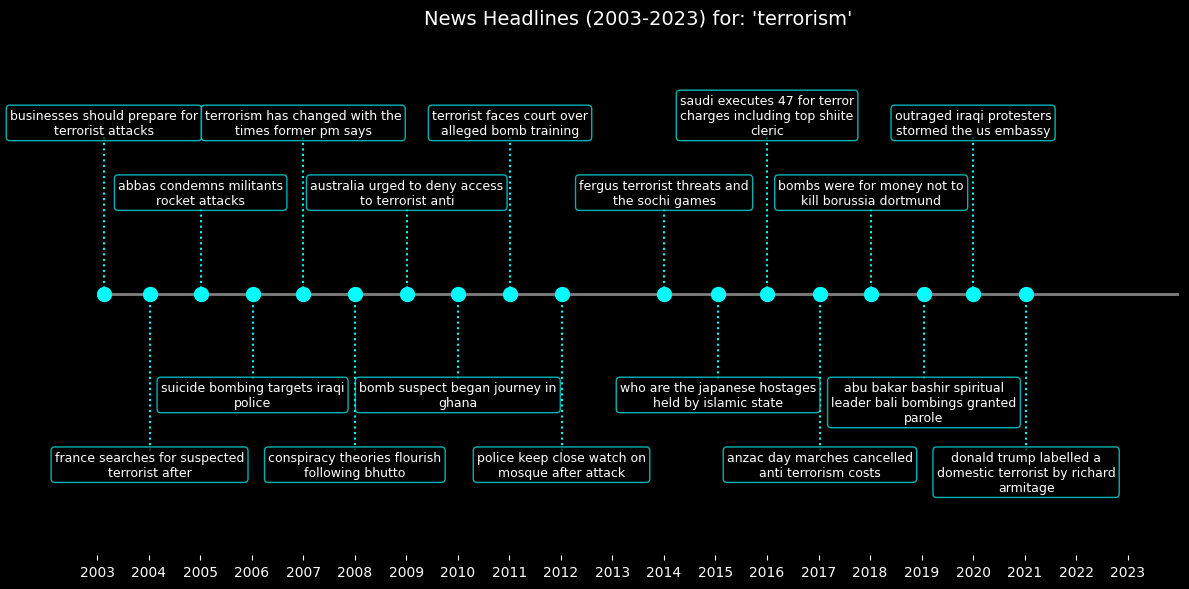

In [63]:
# Visualize news timeline

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,6))
ax.axhline(0, color='gray', linewidth=2, zorder=1)

y_levels = np.tile([1.8, -1.8, 1.0, -1.0], len(milestone_positions) // 4 + 1)[:len(milestone_positions)]

for (date_object, headline), y in zip(milestone_positions, y_levels):
    x_pos = date_object
    ax.scatter(x_pos, 0, s=100, color='cyan', zorder=5) 
    ax.vlines(x_pos, 0, y, color='cyan', linestyle='dotted')

    wrapped_headline = '\n'.join(textwrap.wrap(headline, width=30)) # Use textwrap
    ax.text(x_pos, y, wrapped_headline, 
            ha='center', 
            va='bottom' if y > 0 else 'top',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", fc="black", ec="cyan", lw=1, alpha=0.7),
            zorder=10)
    
    ax.set_xlim(date(2003, 1, 1), date(2023, 12, 31))
    ax.set_ylim(-3, 3)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.title(f"News Headlines (2003-2023) for: '{search_query}'", fontsize=14)
plt.tight_layout()
plt.show()